In [1]:
import os
import re
import json
import time
import datetime
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import string
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
cc = SmoothingFunction()
%matplotlib inline

In [2]:
stop = stopwords.words('english') + list(string.punctuation)

In [3]:
def get_seconds(time_str):
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

def get_minutes(seconds):
    return seconds/60

def get_time_string(time_float):
    return datetime.datetime.utcfromtimestamp(time_float).strftime('%M:%S')

# Log Processor

In [4]:
class Log:
    def __init__(self, logfile):
        self.game_id = logfile['game_id']
        self.domain_id = logfile['domain_id']
        self.agent_ids = logfile['agent_ids']
        self.agent_labels = logfile['agent_labels']
        self.feedback = logfile['feedback']
        self.rounds, self.complete = self.load_rounds(logfile['rounds'])
        self.score = self.calculate_score()
        self.duration = self.calculate_duration()
        self.domains = self.get_domains()
        self.calculate_timestamps()
        self.check_feedback()

    def load_rounds(self, game_rounds):
        rounds = []
        for round_data in game_rounds:
            game_round = GameRound(round_data)
            rounds.append(game_round)
        if len(rounds) < 5:
            print("ERROR: Missing rounds in this game.")
            return (rounds, False)
        return (rounds, True)

    def calculate_score(self):
        score = 0
        for game_round in self.rounds:
            score += game_round.score
        return score
    
    def get_domains(self):
        path = self.rounds[0].images["A"][0][0].split("/")[0]
        return [domain for domain in path.split("_")]

    def calculate_timestamps(self):
        start_time = self.rounds[0].messages[0].timestamp
        for game_round in self.rounds:
            for mesage in game_round.messages:
                mesage.timestamp = datetime.datetime.utcfromtimestamp(mesage.timestamp - start_time)

    def calculate_duration(self):
        start_time = self.rounds[0].messages[0].timestamp
        end_time = self.rounds[-1].messages[-1].timestamp
        return get_time_string(end_time - start_time)
    
    def check_feedback(self):
        if "A" not in self.feedback:
            self.feedback["A"] = None
        if "B" not in self.feedback:
            self.feedback["B"] = None
            

class GameRound:
    def __init__(self, logfile_entry):
        self.round_nr = logfile_entry['round_nr']+1
        self.images = logfile_entry['images']
        self.score = self.calculate_score(logfile_entry['score'])
        if self.score > 6:
            print("WARNING: SCORE TOO LARGE!")
            self.score = 6
        self.messages = self.load_messages(logfile_entry['messages'])
        self.num_messages = self.count_text_messages()
        self.duration = self.calculate_duration(self.round_nr)
#         print("Duration: {}".format(self.duration))

    def load_messages(self, message_list):
        messages = []
        message_id = 0
        for message_data in message_list:
            message = Message(message_data, message_id)
            messages.append(message)
            message_id += 1
            
        if len(messages) == 0:
            print('ERROR: Missing messages for this game')
        return messages

    def calculate_score(self, score_dict):
        score = 0
        for player_score in score_dict.values():
            score += player_score
        return score
    
    def count_text_messages(self):
        count = 0
        for message in self.messages:
            if message.type == "text":
                count += 1
        return count

    def calculate_duration(self, round_nr):
        start_time = self.messages[0].timestamp
#         print("Start Time: {}".format(get_time_string(start_time)))
        
        for message in self.messages[::-1]:
            if message.type == 'feedback': 
                end_time = message.timestamp
#                 print("Last player submitted: {}".format(get_time_string(end_time)))
                return get_time_string(end_time - start_time)

class Message:
    def __init__(self, logfile_message, message_id):
        self.message_id = message_id
        self.agent_id = logfile_message['agent_id']
        self.agent_label = logfile_message['agent_label']
        self.text = logfile_message['message']
        self.speaker = logfile_message['speaker']
        self.timestamp = logfile_message['timestamp']
        self.turn = logfile_message['turn']
        self.type = self.determine_message_type()
        
    def determine_message_type(self):
        if not self.text.startswith("<"):
            return "text"
        else:
            return re.findall(r'<(.*?)>', self.text)[0]

In [5]:
def load_logs(filepath="ParlAI/parlai/mturk/core/logs/batch_1"):
    print("Loading logs from {}".format(filepath))
    logs = []
    for root, dirs, files in os.walk(filepath):
        for file in files:
            if file.endswith(".json"):
                print("Loading {}".format(os.path.join(root, file)))
                with open(os.path.join(root, file), 'r') as logfile:
                    log = Log(json.load(logfile))
                    if log.complete: 
                        logs.append(log)
                    else:
                        print("GAME NOT COMPLETED")

    print("Complete. Loaded {} logs.".format(len(logs)))
    return logs


def get_messages(log, split=False, print_selections=True):
    message_list = []
    if len(log.rounds) != 5:
        print("Conversation was not completed.")
        return []
    for game_round in log.rounds:
        round_messages = []
        for message in game_round.messages:
            if message.type == 'text' or (print_selections and message.type == 'selection') :   
                round_messages.append((message.timestamp, message.speaker, message.text))

        if split:
            message_list.append(round_messages)
        else:
            message_list.extend(round_messages)
    return message_list


def print_conversation(log, split=False, print_selections=True, to_file = False):
    message_list = get_messages(log, split, print_selections)
    
    print("Game ID: {}".format(log.game_id))
    print("Domain ID: {}".format(log.domain_id))
    print("Player A: {}".format(log.agent_ids[0]))
    print("Player B: {}".format(log.agent_ids[1]))
    
    if to_file:
        if not os.path.exists("transcripts"):
            os.makedirs("transcripts")
        with open('transcripts/{}.txt'.format(log.game_id), 'w') as f:
            f.write("Game ID: {}\n".format(log.game_id))
            f.write("Domain ID: {}\n".format(log.domain_id))
            f.write("Player A: {}\n".format(log.agent_ids[0]))
            f.write("Player B: {}\n\n".format(log.agent_ids[1]))
    
    if split:
        for i, round_messages in enumerate(message_list):            
            print("- - Round {} - -".format(i+1))
            if to_file:
                with open('transcripts/{}.txt'.format(log.game_id), 'a') as f:
                    f.write("- - Round {} - -\n".format(i+1))
            messages = print_messages(round_messages)
            if to_file:
                with open('transcripts/{}.txt'.format(log.game_id), 'a') as f:
                    f.write(messages)
    else:
        messages = print_messages(message_list)
        if to_file:
            with open('transcripts/{}.txt'.format(log.game_id), 'a') as f:
                f.write(messages)
#     print(log.feedback)


def print_messages(message_list):
    messages = ""
    for message in message_list:
        timestamp = message[0].strftime('%M:%S')
        print("[{}] {}: {}".format(timestamp, message[1], message[2]))
        messages += "[{}] {}: {}\n".format(timestamp, message[1], message[2])
    return messages


def print_game_statistics(log, to_file=False):
    print("\n- - Game statistics - -")
    print("Duration: {} min. Score: {}/30 points.".format(log.duration, log.score))
    
    if to_file:
        with open('transcripts/{}.txt'.format(log.game_id), 'a') as f:
            f.write("\n- - Game statistics - -\n") 
            f.write("Duration: {} min. Score: {}/30 points.\n".format(log.duration, log.score)) 
    stats = ""
    for i, game_round in enumerate(log.rounds):
        print("[Round {}] Duration: {} min. Score: {}/6 points. Number of messages: {}.".format(i, game_round.duration, game_round.score, game_round.num_messages))
        stats += "[Round {}] Duration: {} min. Score: {}/6 points. Number of messages: {}.\n".format(i, game_round.duration, game_round.score, game_round.num_messages)
        
    if to_file:
            with open('transcripts/{}.txt'.format(log.game_id), 'a') as f:
                f.write(stats)

In [6]:
def collect_dataset(logs):
    labels = ["Game_ID", "Game_Domain_ID", "Game_Domain_1", "Game_Domain_2", "Game_Duration", "Game_Score", \
              "Feedback_A", "Feedback_B", \
              "Round_Nr", "Round_Duration", "Round_Scores", "Round_Images_A", "Round_Images_B", \
              "Message_Nr", "Message_Timestamp", "Message_Turn", "Message_Agent_ID", "Message_Agent_Label", \
              "Message_Speaker", "Message_Type", "Message_Text"]
    dataset = []
    for log in logs:
        game_data = [log.game_id, log.domain_id, log.domains[0], log.domains[1], get_seconds(log.duration), log.score, log.feedback["A"], log.feedback["B"]]
        for game_round in log.rounds:
            round_data = [game_round.round_nr, get_seconds(game_round.duration), game_round.score, game_round.images["A"], game_round.images["B"]]
            for message in game_round.messages:
                message_data = [message.message_id, message.timestamp, message.turn, message.agent_id, message.agent_label, \
                                message.speaker, message.type, message.text] 
                dataset.append(game_data + round_data + message_data)
                
    df = pd.DataFrame(dataset, columns=labels)
                
    return df 

# Print recorded Conversations

In [7]:
path = "logs/"

In [8]:
logs = load_logs(path)
nr_logs = len(logs)
for i, log in enumerate(logs):
    print("\n- - Game {} - -".format(i+1))

    print_conversation(log, split=True, print_selections=True, to_file=True)    
    print_game_statistics(log, to_file=True)

Loading logs from logs/
Loading logs/dmg_pilot_data_3018Q3ZVOJOCM0R6CJK6H5MIV1PRAU_3I3WADAZ9R2CJHN9PVCLFZ1RS055OU_30.json
Loading logs/dmg_pilot_data_304SM51WA42T6PWBXMK72QBJVFBSBE_3X0H8UUIT2MLUSUMSDG3P4O45GTSWU_23.json
Loading logs/dmg_pilot_data_30LB5CDZND8PNEFFUYHQE2C3S2KZ0Z_35LDD5557B2R1XN0J21EPKV3RW7KM8_6.json
Loading logs/dmg_pilot_data_30MVJZJNHNBHJTYOC8XXJJP7F2UJ9W_3Z7ISHFUH1T753KIP2U57HIMEUQZ89_0.json
Loading logs/dmg_pilot_data_31EUONYN2W1THB2OVMUYJXVQ5NCVOU_3X87C8JFV79GAVY0G4HXXF6JLK0SQU_20.json
Loading logs/dmg_pilot_data_31IBVUNM9TXZBYPVWJB8W3MBAUJVFH_3SB4CE2TJWTWJWDILIQY6N85TPAAXI_3.json
Loading logs/dmg_pilot_data_31JLPPHS2VS95205BCOS0237E4R3OF_39L1G8WVWRPO9AT45AQHO6QZLTH13Q_7.json
Loading logs/dmg_pilot_data_31LVTDXBL88TIJIA9A9WQJ2TPDYLRG_39PAAFCODNY9U37WR3GXD71D4WXTVK_2.json
Loading logs/dmg_pilot_data_3B837J3LDPUGMWD0TJ6X25GND0GSRR_3J88R45B2HW360JKA18VWIX0RXUXPC_18.json
Loading logs/dmg_pilot_data_3B837J3LDPUGMWD0TJ6X25GNEEVRSY_317HQ483I8Q6DKICV0V2PJ5Q4J4NIE_51.json
E

Loading logs/dmg_pilot_data_36AHBNMV1SAJH864AO32F2NLJQ7DYO_3SBEHTYCWO10PJMQ224D6Z3YBVFIYV_20.json
Loading logs/dmg_pilot_data_36H9ULYP63SQK3P1FUXPTFBHEU6JFN_3NJM2BJS4X4F328PJ5C8I5CQQGLCP6_0.json
Loading logs/dmg_pilot_data_36U2A8VAG2XRVECE25PPJFIAZTIKY4_3BF51CHDTW83WTFLOCBJEV8YV0C0HU_33.json
Loading logs/dmg_pilot_data_378XPAWRUDBZT1ONMWQX3DLQ5C7AIJ_3X65QVEQI1LPCHTRRDJ11O36MJOLCC_57.json
Loading logs/dmg_pilot_data_378XPAWRUDBZT1ONMWQX3DLQ5CBAIN_3WT783CTPCFDZ87F00U7NL71APCCBI_35.json
Loading logs/dmg_pilot_data_37QW5D2ZRHKA4RY4UA0XBOLIOLW8SQ_3SKRO2GZ72PU581BQGIG5S70TLDK11_18.json
Loading logs/dmg_pilot_data_37QW5D2ZRHKA4RY4UA0XBOLJRFQS8X_36U2A8VAG2XRVECE25PPJFIB30IKYO_40.json
Loading logs/dmg_pilot_data_37UEWGM5HU6GSCE6G0RD64TFR7R1RO_3ZAK8W07I5C81FL5OBIIXAXPTEPU0I_7.json
Loading logs/dmg_pilot_data_37UQDCYH6YTMW5APE0DW8B9UC6XV7A_3IO1LGZLKAV5HT07NXXUAJPQ6XD86K_18.json
Loading logs/dmg_pilot_data_382M9COHEID7S50ZWIHXIZZTMM7UEP_3KYQYYSHYW57NU2241U4DBPJ4ORODM_25.json
ERROR: Missing rounds 

[00:12] A: I have the photo you mentioned
[00:16] B: <selection> <com> person_car/COCO_train2014_000000563545.jpg
[00:17] A: <selection> <com> person_car/COCO_train2014_000000563545.jpg
[00:29] B: i don't have the one you mentioned
[00:39] A: Is there two guys in the background of yours and also a red car?
[00:45] A: <selection> <dif> person_car/COCO_train2014_000000282514.jpg
[00:48] B: yes
[00:53] A: ok same then
[01:18] B: I also have one of a man and woman sitting on a bus I think
[01:25] B: they're both wearing black shirts
[01:37] A: I do not have that one
[01:41] B: <selection> <dif> person_car/COCO_train2014_000000011619.jpg
[01:41] A: I gave a woman standing on a step of some sort next to an open trunk and two suit cases
[01:55] A: she's wearing a rainbow scarf
[02:08] B: I have that one
[02:10] B: <selection> <com> person_car/COCO_train2014_000000394151.jpg
[02:14] A: <selection> <com> person_car/COCO_train2014_000000394151.jpg
[02:30] A: Are you finished?
[02:35] B: yes
[02:

[03:44] B: perfect
- - Round 2 - -
[04:38] B: i have a little boy in blue pj's holding a black phone to his stuffed animals ear
[04:53] A: I have same picture as before with woman with the tattoo sitting on bed next to standing man
[05:11] A: I have the little boy in blue but it is NOT highlighted for me
[05:18] B: <selection> <dif> person_bed/COCO_train2014_000000575631.jpg
[05:26] B: i don't have the tattooed woman
[05:58] B: i have an older woman on her laptop with shorter red/brown hair, you can see her face in the mirror
[06:17] A: Don't have that
[06:21] B: <selection> <dif> person_bed/COCO_train2014_000000348269.jpg
[06:38] A: I have a woman in bed reading a book that obscures her face
[06:50] A: <selection> <dif> person_bed/COCO_train2014_000000528563.jpg
[06:52] B: i don't have that
[06:57] B: <selection> <dif> person_bed/COCO_train2014_000000112029.jpg
[07:04] B: no matches it is
[07:14] A: I also have a person in a bed and the picture is of their feet and brown pants
[07:33]

[06:42] A: I don't have that
[06:45] A: <selection> <dif> person_cake/COCO_train2014_000000447941.jpg
[06:46] B: <selection> <dif> person_cake/COCO_train2014_000000488127.jpg
[06:46] A: <selection> <dif> person_cake/COCO_train2014_000000478537.jpg
- - Round 5 - -
[07:19] B: 4 navy guys.
[07:27] A: Nope
[07:30] B: <selection> <dif> person_cake/COCO_train2014_000000447941.jpg
[07:39] B: 2 men in uniform, red and white striped cake.
[07:52] A: Not that either
[07:56] B: <selection> <dif> person_cake/COCO_train2014_000000481931.jpg
[08:06] B: 3 white uniforms, cutting cake together.
[08:10] A: Yes
[08:14] A: <selection> <com> person_cake/COCO_train2014_000000052928.jpg
[08:15] B: <selection> <com> person_cake/COCO_train2014_000000052928.jpg
[08:17] A: <selection> <dif> person_cake/COCO_train2014_000000488127.jpg
[08:18] A: <selection> <dif> person_cake/COCO_train2014_000000055912.jpg
[08:25] B: Submitted.

- - Game statistics - -
Duration: 09:15 min. Score: 28/30 points.
[Round 0] Duration

[04:46] B: <selection> <dif> person_bicycle/COCO_train2014_000000527112.jpg
[04:47] A: Do you have the handstand guy?
[04:51] A: <selection> <dif> person_bicycle/COCO_train2014_000000266311.jpg
[04:52] A: <selection> <dif> person_bicycle/COCO_train2014_000000256981.jpg
[04:54] B: no
[05:11] B: do you have a guy squatting looking at something
[05:16] A: No
[05:23] B: <selection> <dif> person_bicycle/COCO_train2014_000000441488.jpg
[05:35] B: what else do you need
[05:40] A: That's all
[05:47] A: I'm ready
[06:07] B: mine didn't go away
[06:26] B: oops you must have had the squatting guy
[06:32] B: but that's ok
- - Round 3 - -
[06:45] A: Mine just changed!
[06:49] B: do you have green doors
[06:57] A: No, I don't
[07:01] B: <selection> <dif> person_bicycle/COCO_train2014_000000293658.jpg
[07:05] A: I have the orange shirt guy again
[07:08] B: do you have orange shirt
[07:12] A: <selection> <com> person_bicycle/COCO_train2014_000000256981.jpg
[07:12] B: yes
[07:16] B: <selection> <com> p

[04:12] B: no
[04:15] A: <selection> <com> person_teddy_bear/COCO_train2014_000000127441.jpg
- - Round 2 - -
[05:03] B: an infant sleeping between two teddy bears?
[05:15] A: Yes
[05:17] A: I have the baby with pacifier and bear on top. Do you?
[05:25] A: <selection> <com> person_teddy_bear/COCO_train2014_000000374391.jpg
[05:34] B: <selection> <com> person_teddy_bear/COCO_train2014_000000374391.jpg
[05:37] B: no
[05:41] A: <selection> <dif> person_teddy_bear/COCO_train2014_000000151764.jpg
[05:58] B: guy in white shirt says 'road kill' and a bear beside him?
[06:18] A: No
[06:21] B: <selection> <dif> person_teddy_bear/COCO_train2014_000000127441.jpg
[06:22] A: Do you have a little girl with woman in red both looking down at something?
[06:35] B: yes
[06:37] B: <selection> <com> person_teddy_bear/COCO_train2014_000000231675.jpg
[06:39] A: <selection> <com> person_teddy_bear/COCO_train2014_000000231675.jpg
[06:44] B: That's it for me. Any more?
[06:48] A: No
- - Round 3 - -
[07:09] A: I

[04:05] A: Nope!
[04:15] A: Paying off my debts one mturk hit at a time :)
[04:21] B: <selection> <dif> person_bicycle/COCO_train2014_000000441488.jpg
[04:22] B: <selection> <dif> person_bicycle/COCO_train2014_000000386326.jpg
[04:23] B: <selection> <dif> person_bicycle/COCO_train2014_000000527112.jpg
[04:30] B: You did have one of those.
[04:33] B: I got it wrong.
[04:42] B: Gotta check your not-highlighted ones, too.
- - Round 2 - -
[04:46] A: Not highlighted though
[04:55] A: Oh.. I didn't know that
[05:03] B: Yeah, my highlighted ones are different than yours.
[05:20] B: So I can have 3 of any of your 6 images.
[05:25] A: Pink skirt no hands on handlebars
[05:33] B: I don't have that, no.
[05:39] A: I see. It didnt work like that for me last round
[05:53] B: It's fine. You learn.
[06:46] B: What else do you have highlighted? Just keep going until your 3 are done, then we do my 3.
[06:49] B: One at a time, of course.
[07:12] A: two people with white bikes in front of a train
[07:18]

[29:49] A: Yes.. the  white cake...knife poised striped yellow purple green red stripes
[29:53] A: <selection> <com> cake_dining_table/COCO_train2014_000000501718.jpg
[30:08] B: Yes the white cake is not highlighted but we have it in common
[30:15] A: My white cake with knife isn't hi lit but it is here.
[30:32] A: I have mine, you?
[30:43] B: Yes any questons?
[30:52] A: No I got it thanks so much.
[31:04] B: Thank you and good luck!

- - Game statistics - -
Duration: 31:38 min. Score: 30/30 points.
[Round 0] Duration: 06:26 min. Score: 6/6 points. Number of messages: 25.
[Round 1] Duration: 07:30 min. Score: 6/6 points. Number of messages: 26.
[Round 2] Duration: 07:40 min. Score: 6/6 points. Number of messages: 34.
[Round 3] Duration: 02:48 min. Score: 6/6 points. Number of messages: 15.
[Round 4] Duration: 03:46 min. Score: 6/6 points. Number of messages: 19.

- - Game 189 - -
Game ID: 33LKR6A5KFIT8RRYKPW86JUWCZT1TF3P1L2B7AD2NQL6QUHISSWOXNBXGOLL
Domain ID: 3
Player A: A7R6YNXS5YAE6

[04:37] A: no birthday cake here
[04:39] B: yes
[04:42] A: <selection> <com> cake_dining_table/COCO_train2014_000000501718.jpg
[04:46] A: That's all for me.
[04:53] B: me too
[04:56] B: <selection> <com> cake_dining_table/COCO_train2014_000000235744.jpg
[04:59] B: <selection> <com> cake_dining_table/COCO_train2014_000000501718.jpg
- - Round 3 - -
[05:21] A: upside down cake with background bananas
[05:27] B: baby touching birthday cake
[05:37] A: yes.  I have the baby
[05:39] A: <selection> <com> cake_dining_table/COCO_train2014_000000126144.jpg
[05:41] B: <selection> <com> cake_dining_table/COCO_train2014_000000126144.jpg
[05:51] A: I also have the birthday cake with lit candles this time.
[05:53] A: <selection> <com> cake_dining_table/COCO_train2014_000000235744.jpg
[05:56] B: no
[06:01] A: <selection> <dif> cake_dining_table/COCO_train2014_000000235744.jpg
[06:10] B: i mean yes i have the birthday cake with candles
[06:14] A: <selection> <com> cake_dining_table/COCO_train2014_000000

# Create Dataframe

In [9]:
dataset = collect_dataset(logs)
dataset.columns

Index(['Game_ID', 'Game_Domain_ID', 'Game_Domain_1', 'Game_Domain_2',
       'Game_Duration', 'Game_Score', 'Feedback_A', 'Feedback_B', 'Round_Nr',
       'Round_Duration', 'Round_Scores', 'Round_Images_A', 'Round_Images_B',
       'Message_Nr', 'Message_Timestamp', 'Message_Turn', 'Message_Agent_ID',
       'Message_Agent_Label', 'Message_Speaker', 'Message_Type',
       'Message_Text'],
      dtype='object')

In [10]:
dataset.to_csv('conversations.csv', index = False)

In [11]:
dataset.to_pickle('conversations.pickle')

In [12]:
game_times = dataset.groupby('Game_ID').mean()['Game_Duration']
game_times_list = [get_minutes(duration) for duration in list(game_times)]
# print(game_times_list)
print(min(game_times_list))
print(max(game_times_list))

1.66666666667
51.7333333333


## Average Game Time

In [13]:
print(np.mean(game_times_list))

15.6138528139


In [14]:
under_12 = [time for time in game_times_list if time < 10]
print(len(under_12))

39


## Distribution of Game Times

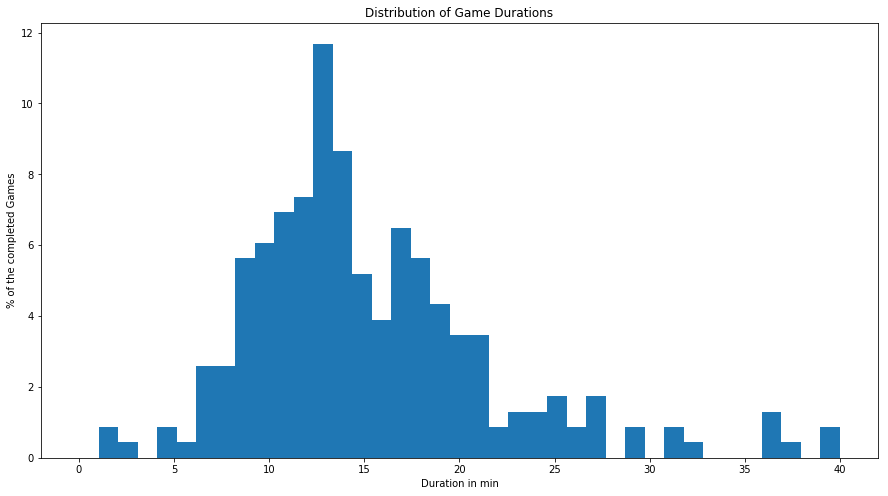

In [15]:
f = plt.figure(figsize=(15,8))
plt.hist(game_times_list, bins=np.linspace(0,40,40), weights=np.zeros_like(game_times_list) + 100. / len(game_times_list))  # arguments are passed to np.histogram
plt.title("Distribution of Game Durations")
plt.xlabel("Duration in min")
plt.ylabel("% of the completed Games")
plt.draw()
ax = plt.gca()
xticks = [str(label.get_text())+" min" for label in ax.get_xticklabels()][1:-1]
ax.set_xticklabels = xticks
plt.draw()
plt.show()
f.savefig("time_distro.pdf", bbox_inches='tight')

# Game Statistics

In [16]:
games_df = dataset.groupby('Game_ID')

In [76]:
points = []

for _, game in games_df:
    points.append(game["Game_Score"].unique()[0])
    
p_counter = Counter(points)
print(p_counter)

Counter({30: 108, 28: 49, 29: 40, 27: 21, 26: 8, 25: 2, 24: 2, 17: 1})


In [78]:
points = []

for _, game in games_df:
    rounds_df = game_df[1].groupby('Round_Nr')
    for _, g_round in rounds_df:
        points.append(g_round["Round_Scores"].unique()[0])
    
p_counter = Counter(points)
print(p_counter)

Counter({6: 1155})


In [17]:
game_statistics = defaultdict(lambda: (defaultdict(lambda: [])))

for game_df in games_df:
#     print("Game {}".format(game_df[0]))
    rounds_df = game_df[1].groupby('Round_Nr')
    for round_df in rounds_df:
#         print("Round {}".format(round_df[0]))
        player_data_df = round_df[1].groupby('Message_Agent_ID')
        token_sum = 0
        message_sum = 0
        for player_df in player_data_df:
            
            messages = player_df[1].loc[player_df[1]['Message_Type'] == 'text']
            message_list = messages['Message_Text'].tolist()
            no_tokens = 0
            for m in message_list:
                tokens = [i for i in word_tokenize(m.lower()) if i not in stop]
#                 print(tokens)
#                 print(len(tokens))
                no_tokens += len(tokens)
            token_sum += no_tokens
            message_sum += len(message_list)
#             print("Agent {} used {} tokens in {} messages.".format(player_df[0], no_tokens, len(message_list)))
            
        game_statistics["tokens"][round_df[0]].append(token_sum)
        game_statistics["messages"][round_df[0]].append(message_sum)
        game_statistics["duration"][round_df[0]].append(round_df[1].mean()["Round_Duration"])
#         print("Total tokens: {}. Total messages: {}. Duration: {}".format(token_sum, message_sum, get_time_string(round_df[1].mean()["Round_Duration"])))
#     print("\n-------\n")
   

In [18]:
def plot_game_data(mu, sigma, t, title, x_label, y_label, filename=None):
    fig, ax = plt.subplots(1, figsize=(10,6))
    ax.plot(t, mu, lw=2, label='mean population 1', color='blue')
    ax.fill_between(t, mu+sigma, mu-sigma, facecolor='blue', alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticks(t)
    ax.grid()
    fig.show()
    if filename:
        fig.savefig(filename, bbox_inches='tight')

## Word Tokens per Round

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


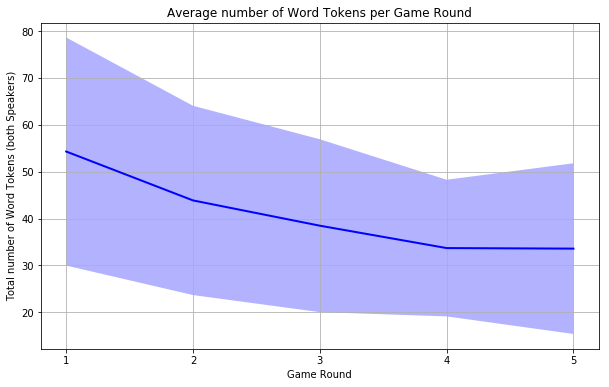

In [19]:
data_array = np.empty([5, nr_logs])

for round_nr, token_counts in game_statistics["tokens"].items():    
#     print("Round {}: Token counts {}".format(round_nr, token_counts))
    data_array[round_nr-1] = token_counts
    
mu = data_array.mean(axis=1)
sigma = data_array.std(axis=1)
t = np.arange(1, 6, 1)

title = 'Average number of Word Tokens per Game Round'
x_label = 'Game Round'
y_label = 'Total number of Word Tokens (both Speakers)'
filename = 'tokens.pdf'


plot_game_data(mu, sigma, t, title, x_label, y_label, filename)

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


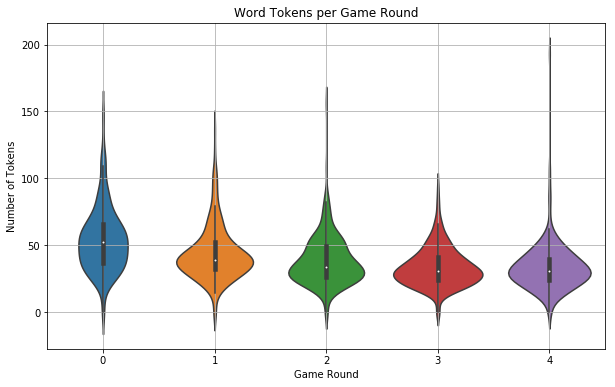

In [20]:
message_df = pd.DataFrame(data_array.T)
fig, ax = plt.subplots(1, figsize=(10,6))
ax = sns.violinplot(data=message_df)    
    
ax.set_title("Word Tokens per Game Round")
ax.set_xlabel("Game Round")
ax.set_ylabel("Number of Tokens")
# ax.set_ylim(-10,500)
# ax.set_xticks(t)
ax.grid()
fig.show()
if filename:
    fig.savefig("tokens_violin_cut.pdf", bbox_inches='tight')


## Vocabulary

In [67]:
messages = dataset.loc[dataset['Message_Type'] == 'text']['Message_Text'].tolist()

tokens = []
for message in messages:        
    tokens.extend([i for i in word_tokenize(message.lower())])

token_counter = Counter(tokens)
print("Vocabulary size: {} tokens.".format(len(token_counter)))
print(token_counter.most_common(500))

Vocabulary size: 3349 tokens.
[('have', 4851), ('a', 4627), ('i', 4405), ('the', 4148), ('.', 3343), ('?', 3010), ('with', 2799), ('do', 2564), (',', 2162), ('no', 2003), ('in', 1953), ('on', 1941), ('you', 1933), ('and', 1689), ('one', 1680), ('yes', 1661), ('that', 1563), ('of', 1146), ('it', 1031), ('guy', 885), ('red', 839), ('is', 837), ("n't", 783), ('white', 779), ('man', 769), ('to', 709), ('woman', 703), ('shirt', 610), ('not', 608), ('ok', 606), ('blue', 557), ('black', 543), ('cake', 524), ('again', 480), ('green', 464), ('two', 441), ("'s", 414), ('!', 409), ('done', 399), ('too', 390), ('nope', 378), ('me', 358), ('girl', 345), ('next', 339), ('bike', 328), ('all', 323), ('lady', 318), ('for', 306), ('orange', 303), ('my', 297), ('at', 294), ('holding', 288), ('front', 269), ('got', 258), ('this', 258), ('same', 256), ('an', 255), ('2', 243), ('laptop', 241), ('are', 238), ('okay', 234), ('about', 233), ('picture', 231), ('wearing', 227), ('yellow', 224), ('dog', 224), ('b

## Messages per Round

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


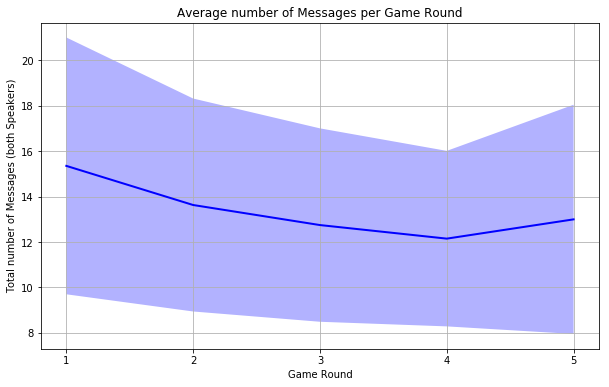

In [22]:
data_array = np.empty([5, nr_logs])

for round_nr, message_counts in game_statistics["messages"].items():    
#     print("Round {}: Message counts {}".format(round_nr, message_counts))
    data_array[round_nr-1] = message_counts
    
mu = data_array.mean(axis=1)
sigma = data_array.std(axis=1)
t = np.arange(1, 6, 1)

title = 'Average number of Messages per Game Round'
x_label = 'Game Round'
y_label = 'Total number of Messages (both Speakers)'
filename = 'messages.pdf'


plot_game_data(mu, sigma, t, title, x_label, y_label, filename)

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


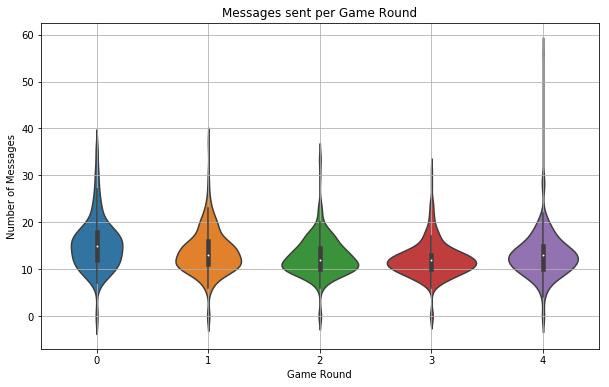

In [23]:
message_df = pd.DataFrame(data_array.T)
fig, ax = plt.subplots(1, figsize=(10,6))
ax = sns.violinplot(data=message_df)    
    
ax.set_title("Messages sent per Game Round")
ax.set_xlabel("Game Round")
ax.set_ylabel("Number of Messages")
# ax.set_ylim(-10,500)
# ax.set_xticks(t)
ax.grid()
fig.show()
if filename:
    fig.savefig("messages_violin_cut.pdf", bbox_inches='tight')


## Duration per Round

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


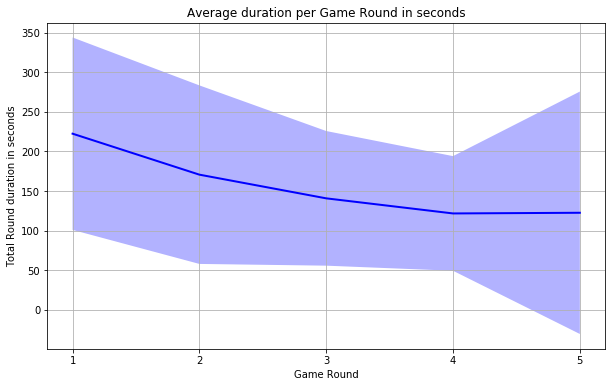

In [24]:
data_array = np.empty([5, nr_logs])

for round_nr, duration in game_statistics["duration"].items():    
#     print("Round {}: Duration {}".format(round_nr, duration))
    data_array[round_nr-1] = duration
    
mu = data_array.mean(axis=1)
sigma = data_array.std(axis=1)
t = np.arange(1, 6, 1)

title = 'Average duration per Game Round in seconds'
x_label = 'Game Round'
y_label = 'Total Round duration in seconds'
filename = 'duration.pdf'


plot_game_data(mu, sigma, t, title, x_label, y_label, filename)

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


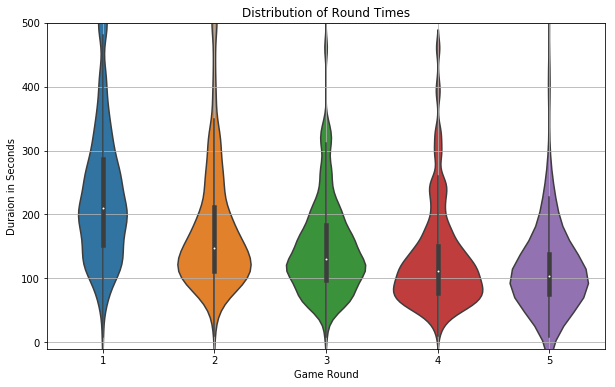

In [25]:
fig, ax = plt.subplots(1, figsize=(10,6))
ax = sns.violinplot(x="Round_Nr", y="Round_Duration", data=dataset)    
    
ax.set_title("Distribution of Round Times")
ax.set_xlabel("Game Round")
ax.set_ylabel("Duraion in Seconds")
ax.set_ylim(-10,500)
# ax.set_xticks(t)
ax.grid()
fig.show()
if filename:
    fig.savefig("durations_violin_cut.pdf", bbox_inches='tight')



In [26]:
# for game_id, game_df in games_df:
#     selections = game_df.loc[game_df['Message_Type'] == 'selection']['Message_Text']
#     sel_images = [elements.split()[2] for elements in selections]
#     print(len(set(sel_images)))

## Worker Evaluations

In [27]:
dataset.columns

Index(['Game_ID', 'Game_Domain_ID', 'Game_Domain_1', 'Game_Domain_2',
       'Game_Duration', 'Game_Score', 'Feedback_A', 'Feedback_B', 'Round_Nr',
       'Round_Duration', 'Round_Scores', 'Round_Images_A', 'Round_Images_B',
       'Message_Nr', 'Message_Timestamp', 'Message_Turn', 'Message_Agent_ID',
       'Message_Agent_Label', 'Message_Speaker', 'Message_Type',
       'Message_Text'],
      dtype='object')

In [28]:
games_df = dataset.groupby("Game_ID")

In [29]:
feedback_dict = {0: [], 1: [], 2: []}

for _, f in games_df:
    f_a = f['Feedback_A'].unique()[0]
    f_b = f['Feedback_B'].unique()[0]
    
    if f_a and f_b:    
        elements = f_a.split("<&>")
        for i, element in enumerate(elements):
            value = element.split(":", 1)[1]
            if i < 3:
                feedback_dict[i].append(int(value))
#             else:
#                 print(value)

        elements = f_b.split("<&>")
        for i, element in enumerate(elements):
            value = element.split(":", 1)[1]
            if i < 3:
                feedback_dict[i].append(int(value))
#             else:
#                 print(value)

print("Overall collaboration with my partner worked well:")
print(np.sum(feedback_dict[0]) / float(len(feedback_dict[0])))
print(Counter(feedback_dict[0]))
print("I understood the descriptions of my partner well:")
print(np.sum(feedback_dict[1]) / float(len(feedback_dict[1])))
print(Counter(feedback_dict[1]))
print("My partner seemed to understand me well:")
print(np.sum(feedback_dict[2]) / float(len(feedback_dict[2])))
print(Counter(feedback_dict[2]))

Overall collaboration with my partner worked well:
4.72444444444
Counter({5: 355, 4: 76, 3: 13, 1: 4, 2: 2})
I understood the descriptions of my partner well:
4.69111111111
Counter({5: 348, 4: 74, 3: 20, 2: 7, 1: 1})
My partner seemed to understand me well:
4.74444444444
Counter({5: 360, 4: 74, 3: 8, 2: 7, 1: 1})


In [30]:
scores = defaultdict(lambda: [])

for log in logs:
    for g_round in log.rounds:
        scores[g_round.round_nr].append(g_round.score)  
        
# print(scores)

In [31]:
data_array = np.empty([5, nr_logs])

for round_nr, round_scores in scores.items():    
    print("Round {}: Scores: {}".format(round_nr, round_scores))
    data_array[round_nr-1] = round_scores

Round 1: Scores: [6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 5, 6, 5, 5, 6, 6, 6, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6, 4, 6, 6, 5, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 3, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 4, 5, 6, 6, 6, 6, 5, 5, 6, 4, 6, 6, 6, 6, 5, 6, 4, 4, 6, 6, 6, 6, 4, 6, 6, 6, 5, 6, 6, 5, 6, 4, 5, 6, 5, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 4, 6, 4, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 4, 6, 6, 6, 5, 5, 6, 6, 6]
Round 2: Scores: [6, 6, 6, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 5, 5, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6

[ 5.72294372  5.77489177  5.77922078  5.73160173  5.83116883]


/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


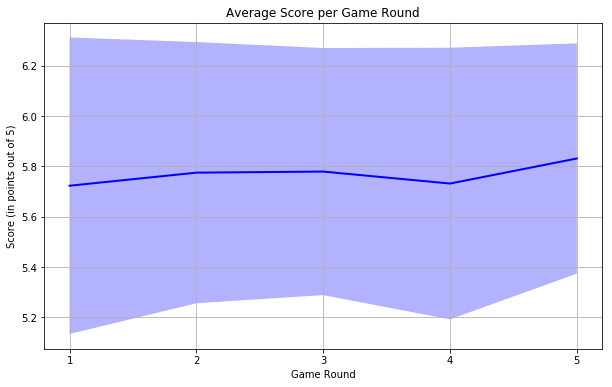

In [32]:
mu = data_array.mean(axis=1)
sigma = data_array.std(axis=1)
t = np.arange(1, 6, 1)

title = 'Average Score per Game Round'
x_label = 'Game Round'
y_label = 'Score (in points out of 5)'
filename = 'points.pdf'


plot_game_data(mu, sigma, t, title, x_label, y_label, filename)
print(mu)

In [33]:
# sns.plot(kind='bar', stacked=True)

/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


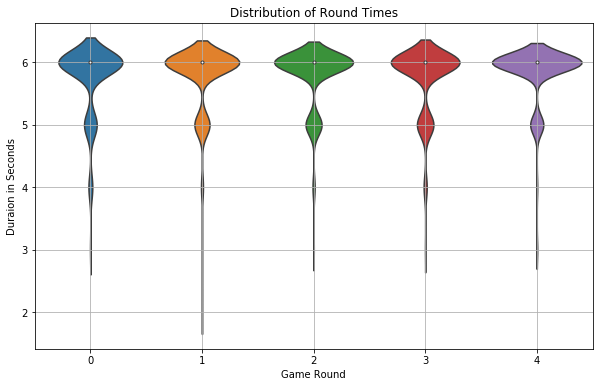

In [34]:
fig, ax = plt.subplots(1, figsize=(10,6))
ax = sns.violinplot(data=data_array.T)    
    
ax.set_title("Distribution of Round Times")
ax.set_xlabel("Game Round")
ax.set_ylabel("Duraion in Seconds")
# ax.set_ylim(-10,500)
# ax.set_xticks(t)
ax.grid()
fig.show()
if filename:
    fig.savefig("points_violin_cut.pdf", bbox_inches='tight')

## Finding questions

In [35]:
message_df = dataset.loc[dataset['Message_Type'] == 'text'][['Message_Text', 'Round_Nr']]
q_words = ['who', 'what', 'when', 'where', 'why', 'how', 'is', 'can', 'does', 'do', 'does']

questions = []
question_stats = defaultdict(lambda: [0,0])
for index, row in message_df.iterrows():
    message = row['Message_Text']
#     print(message)
    if message[-1] == '?' or message.split()[0].lower() in q_words:
#         print("QUESTION")
        questions.append(message)
        question_stats[row['Round_Nr']][1] += 1
    question_stats[row['Round_Nr']][0] += 1

In [36]:
print(message_df.shape[0])
print(len(questions))
print(questions)

15446
3246
['do you have someone using a remote control up close?', 'Hand holding remote and pressing the center button?', 'Guy holding a remote pointed at a green screen?', 'wii controler in hands with feet up on a table?', 'Maybe is he next to a logo that looks like a blueish A?', 'the big remote with the hand pushing the middle button?', 'The person with the wii controller and the feet propped up on a coffee table?', "What's your last one?", 'The person with the wii controller and feet propped up on table?', 'the two girls in front of older tv again?', 'in a red shirt?', "I'm done. Do you have any more?", 'guy in blue polo shirt pointing remote at small tv?', 'big remote?', 'I have the blue polo guy now?', 'feet propped on desk with wii remote?', 'person with wii controller and feet propped up?', 'Purple shirt cord attached?', "I'm done. You?", 'blue polo shirt guy?', 'wii controller with feet propped up?', 'A woman lying down on a surfboard, tan shirt?', 'Male, black wet suit on a 

In [37]:
q_types_dict = defaultdict(lambda: [])

for question in questions:
    q = question.lower()
    if q.startswith("do you have"):
        q_types_dict["do you have"].append(q)
    elif q.startswith("do you"):
        q_types_dict["do you"].append(q)
    elif q.startswith("what"):
        q_types_dict["what"].append(q)
    else:
        q_types_dict["others"].append(q)

In [38]:
q_ngrams_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: [])))

for question in questions:
    q = question.lower()
    q_split = q.split()
    if len(q_split) > 2:
        q_ngrams_dict[q_split[0]][q_split[1]][q_split[2]].append(q)

In [39]:
print(q_ngrams_dict.keys())

dict_keys(['do', 'hand', 'guy', 'wii', 'maybe', 'the', "what's", 'in', "i'm", 'i', 'feet', 'person', 'purple', 'blue', 'a', 'male,', 'is', 'same', 'man', 'what', 'topless', '2', 'guy,', 'sitting', 'got', 'woman', 'red', 'couple', 'red,', 'how', 'with', 'does', 'could', 'boy', 'yay!', 'have', 'haha', 'no', 'any', 'u', 'and', 'last', 'she', 'lady', 'little', 'great!', 'color', 'crazy', 'sounds', 'girl', 'two', 'nope,', 'bike', 'hey,', 'one', 'you', 'orange', 'ponytail', 'looks', 'nope.', 'no.', 'yeah.', 'yeah', 'green', 'no,guy', 'surfer', 'yes.', 'alrighty,', 'all', 'ok', 'are', 'an', 'not', 'yellow,', '3', 'white', 'did', 'k', 'three', 'hello!', 'great.', 'really', 'parked', "she's", 'hes', 'that', 'guying', 'women', 'smiling', 'raedy', 'they', 'asian', 'painting', 'ok.', 'wearing', 'ha', 'but', 'happen', 'wanna', 'yup;', 'brown', 'im', 'hot', 'next', 'hotdog', 'donut', 'mickey', 'macoroons', 'anymore', 'it', 'yes', 'ready', 'okay', 'we', 'bag', 'cake', 'bright', 'kitchen', 'hi,', 'las

In [40]:
print(q_ngrams_dict['do'].keys())

dict_keys(['you', 'yu', 'youhave', 'not', 'yoy', 'we', 'have', 'u', 'they', 'thank'])


In [41]:
print(q_ngrams_dict['do']['you'].keys())

dict_keys(['have', 'a', 'hace', 'the', 'any', 'red', 'havea', 'also', 'still', 'see', 'need', 'happen', 'hav', 'now', 'guys'])


In [42]:
print(q_ngrams_dict['do']['you']['have'])

['do you have someone using a remote control up close?', 'do you have any more questions?', 'do you have the man and woman with their bikes by a train?', 'do you have the man in an orange shirt putting his bike on the front of a bus?', 'do you have the man squatting down with his phone between bikes?', 'do you have orange shirt mounting his bike on the bus?', 'do you have blue garage doors again?', 'do you have a lime green luggage container with a lady with red flats on?', 'do you have a little girl standing next to a bed?', 'do you have a green and black luggage container with someone in blue holding on the green handle', "do you have a brown suitcase with a red tag and wheels with some one's hand on it?", 'do you have someone on a skateboard?', 'do you have the same luggage image as last round? red wheels and tags', 'do you have an asian lady in a hat on a boat filled with what i think are apples?', 'do you have a boy in a lifevest in a boat?', 'do you have the boy in the life jacke

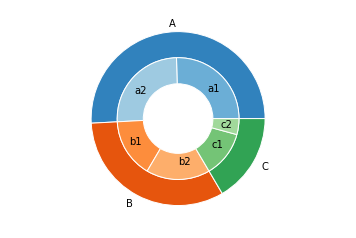

In [43]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.axis('equal')
width = 0.3

cm = plt.get_cmap("tab20c")
cout = cm(np.arange(3)*4)
pie, _ = ax.pie([120,77,39], radius=1, labels=list("ABC"), colors=cout)
plt.setp( pie, width=width, edgecolor='white')

cin = cm(np.array([1,2,5,6,9,10]))
labels = list(map("".join, zip(list("aabbcc"),map(str, [1,2]*3))))
pie2, _ = ax.pie([60,60,37,40,29,10], radius=1-width, labels=labels,
                                      labeldistance=0.7, colors=cin)
plt.setp( pie2, width=width, edgecolor='white')
plt.show()

In [44]:
for key, values in q_types_dict.items():
    print("{}: {}".format(key, len(values)))

do you have: 982
others: 2131
what: 90
do you: 43


In [45]:
from decimal import *
getcontext().prec = 3

t = 0.30000000000000000000000000000000000000000000004
t = round(t,2)
t

0.3

In [46]:
from decimal import *
getcontext().prec = 2
Decimal(1.0) / Decimal(7)


Decimal('0.14')

In [47]:
print(q_types_dict["what"])

["what's your last one?", 'what about you?', 'what about you?', 'what are your three then?', 'what about a toddler sitting on a bench with a hoodie on?', 'what about people making pizza? they have on white shirts and orange aprons.', 'what else do you have?', 'what about two girls in water and little boy.', 'what about the asian man?', 'whats missing?', 'what about the guy with a surf board standing next to it', 'what about little girl and man decorating a pizza', 'what about the box with godiva writing and a slice of chocolate cake?', 'what is your next one?', 'what about the three kids sitting on the bed, one boy in red between two girls', 'what about the three kids on the edge of the bed, boy between two girls', 'what are the colors of the cup and plate?', 'what about yours', 'what else do you have', 'what about the window and cow one?', "what's your last one?", 'what are your other 2?', "what's your last one, then?", 'what about a little girl pink and white polka dot shirt feeding 

In [48]:
print(q_types_dict["do you"])

['do you a lady next to a panda', 'do youhave the little kid cooking with her dad', 'do you hace one of an elephant holding another elephants tail, with a man next to them', 'do you?', 'do you the child reaching for the cake?', 'do you any questions?', 'do you?', 'do you red bandana?', 'do you also have a car covered with a lot of coloured stuff', 'do you still have a picture?', 'do you see a child eating something in front of a plate with a star on it?', 'do you see a man with a beard slicing a pizza', 'do you see 2 ladied wearing red shirts in behind a table, one is smiling and one is not?', 'do you see a woman and a child in a room wit big windows, the lady has a green shirt on', 'do you see what looks like 2 boys with red shirts lying down in a booth seats at a restaurant? ', 'do you need to ask any other question to me??', 'do you a picture with a woman holding a book, laying on her bed next to her cat?', 'do you need anything else', 'do you a chocolate cake with fork and red napk

In [49]:
question_stats

defaultdict(<function __main__.<lambda>>,
            {1: [3546, 815],
             2: [3148, 675],
             3: [2944, 620],
             4: [2806, 560],
             5: [3002, 576]})

In [50]:
q_stats_df = pd.DataFrame(question_stats).transpose()

In [51]:
q_stats_df

,0,1
1,3546,815
2,3148,675
3,2944,620
4,2806,560
5,3002,576


In [53]:
q_stats_df = q_stats_df.rename(index=str, columns={0: "Statent", 1: "Question"})

In [54]:
q_stats_df

,Statent,Question
1,3546,815
2,3148,675
3,2944,620
4,2806,560
5,3002,576


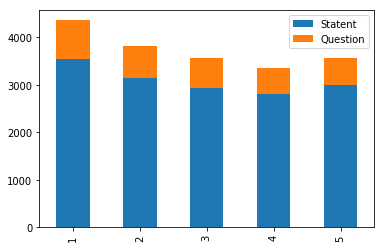

In [55]:
q_stats_df.plot.bar(stacked=True);

In [56]:
q_stats_df = q_stats_df.div(q_stats_df.sum(axis=1), axis=0)

In [57]:
q_stats_df

,Statent,Question
1,0.813116,0.186884
2,0.823437,0.176563
3,0.826038,0.173962
4,0.833630,0.166370
5,0.839016,0.160984


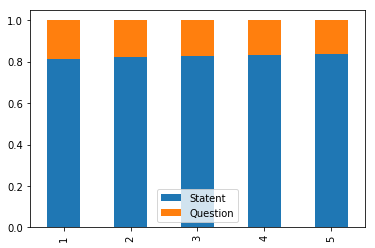

In [58]:
q_stats_df.plot.bar(stacked=True);

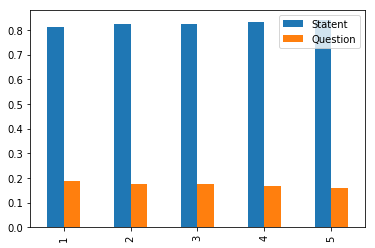

In [59]:
q_stats_df.plot.bar(stacked=False);

## Reference Grounding Heuristiscs

In [60]:
with open('captions_train2014.json', 'r') as f:
    captions = json.load(f)

In [61]:
def make_caption_dict(captions):
    caption_dict = defaultdict(lambda: [])
    for caption in captions['annotations']:
        caption_dict[caption['image_id']].append(caption['caption'])
    return caption_dict

In [62]:
caption_dict = make_caption_dict(captions)

In [63]:
HEURISTICS_VERBOSE = True

game_statistics = defaultdict(lambda: (defaultdict(lambda: [])))

for game_df in games_df:
    
    print(game_df[1]["Game_ID"].unique())
    
    highlighted_images = []
    
    rounds_df = game_df[1].groupby('Round_Nr')
    for round_df in rounds_df:       
        selections = round_df[1].loc[round_df[1]['Message_Type'] == 'selection']['Message_Text'].tolist()      
        highlighted_images.extend([int(image_link.split('_')[-1].split('.')[0].lstrip('0')) for image_link in set([selection.split(" ")[-1] for selection in selections])])
        
    highlighted_images = set(highlighted_images)
#     for image_id in highlighted_images:
#         print("Image {} was captioned as ".format(image_id))
#         print(caption_dict[image_id])
    
    references_proto = dict()
    previous_messages = {"A": [], "B": []}    
    messages = zip(game_df[1]['Message_Text'], game_df[1]['Message_Type'], game_df[1]['Message_Speaker'])
    
    for m_text, m_type, m_speaker in messages:
        if m_type == 'text':
            previous_messages[m_speaker].append(m_text)
        if m_type == 'selection':
            image_link = m_text.split(" ")[-1]
            image_id = int(image_link.split('_')[-1].split('.')[0].lstrip('0'))

            if image_id in references_proto:
                references_proto[image_id]["A"].append(previous_messages["A"][-2:])
                references_proto[image_id]["B"].append(previous_messages["B"][-2:])
            else:                
                references_proto[image_id] = {"A": [previous_messages["A"][-2:]], "B": [previous_messages["B"][-2:]], "captions": caption_dict[image_id]}
    
    reference_dict = defaultdict(lambda: [])

    for image_id, entry in references_proto.items():
        if HEURISTICS_VERBOSE: print("Processing referring expressions for image {}\n".format(image_id))
        if HEURISTICS_VERBOSE: print("Speaker A Sentences: {}\n".format(entry['A']))
        if HEURISTICS_VERBOSE: print("Speaker B Sentences: {}\n".format(entry['B']))

        captions = entry['captions']
        if HEURISTICS_VERBOSE: print("Captions: {}".format(captions))
        
        for ug_A, ug_B in zip(entry['A'], entry['B']):
            
            captions = entry['captions'].copy()
            captions.extend(reference_dict[image_id])
            if HEURISTICS_VERBOSE: print("Captions: {}".format(captions))        
            utterrance_groups = [ug_A] + [ug_B]
#             print(utterrance_groups)
                
            best_match = None
            best_score = 0

            for utterance_group in utterrance_groups:
                best_in_group = None
                best_score_group = 0
                for u in utterance_group:           

                    if HEURISTICS_VERBOSE: print("Utterance: {}".format(u))

                    bleu_score = sentence_bleu(captions, u)
                    if HEURISTICS_VERBOSE: print("BLEU Score with captions: {}".format(bleu_score))

                    if bleu_score < 1 and bleu_score > 0.4 and bleu_score > best_score:
                        best_score_group = bleu_score
                        best_in_group = u  

                if best_score_group > best_score:
                    best_score = best_score_group
                    best_match = best_in_group

            if HEURISTICS_VERBOSE: print("Best Match: {}\n".format(best_match))
            if best_match:
                reference_dict[image_id].append(best_match)
    
    for image_id, descriptions in reference_dict.items():
        references = set(descriptions)
        print("Image {} had references".format(image_id))
        for reference in references:
            print(reference)
        print("\n")   
        
    break
   

['3018Q3ZVOJOCM0R6CJK6H5MIV1PRAU3I3WADAZ9R2CJHN9PVCLFZ1RS055OU']
Processing referring expressions for image 288713

Speaker A Sentences: [['do you have someone using a remote control up close?'], ['do you have someone using a remote control up close?'], ['the big remote with the hand pushing the middle button?', "I don't have the purple shirt guy"], ['the two girls in front of older tv again?', 'no for upclose remote'], ['guy in blue polo shirt pointing remote at small tv?', 'big remote?']]

Speaker B Sentences: [['Hand holding remote and pressing the center button?', 'Yup'], ['Yup', 'Guy holding a remote pointed at a green screen?'], ['I have the purple shirt guy now', 'Nope'], ['up close remote', 'Yup'], ['I have the blue polo guy now?', 'nope']]

Captions: ['a hand is holding a controller and a television set', 'A hand on a remote control pointed at a television.', 'A remote close to the monitor screen ', 'A remote control is being used to control the TV.', 'A person holding a remot

/home/janosch/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/janosch/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/janosch/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [64]:
0/60.0

0.0

In [65]:
references = ['A man on a beach holding a surf board.', 
              'A surfer in a black wet suit holds a surfboard as two people stand in the water behind him.', 
              'A man carries a surfboard down a beach.', 
              'A man carries his surfboard along a beach.', 
              'A man holding a surfboard on top of an ocean.']

hypothesis1 = 'A blonde man wearing a black wet suit holding a surfboad with a shark and a clock on it.'

hypothesis2 = 'Yes, I have that.'
              
print(sentence_bleu(references, hypothesis1))
print(sentence_bleu(references, hypothesis2))

references_tok = [word_tokenize(caption) for caption in references]
             
print(sentence_bleu(references_tok, hypothesis1))
print(sentence_bleu(references_tok, hypothesis2))
              
hypothesis1_tok = word_tokenize(hypothesis1)
hypothesis2_tok = word_tokenize(hypothesis2)

print(sentence_bleu(references_tok, hypothesis1_tok))
print(sentence_bleu(references_tok, hypothesis2_tok))

0.5887071766734622
0.10811281888102361
0.46173663094410267
0.5432852079582625
0.16195570128532405
0.38753858253732953


/home/janosch/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/janosch/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
error_dict = defaultdict(lambda: defaultdict(lambda: 0))

for game_df in games_df:
    print(game_df[1]["Game_ID"].unique())
    rounds_df = game_df[1].groupby('Round_Nr')
    
    seen = []
    
    for round_df in rounds_df:
        round_nr = round_df[0]
#         print(round_df)
#         print(round_df[1]["Round_Images_A"].tolist()[0])
        images_A = [im for im, com in round_df[1]["Round_Images_A"].tolist()[0]]
        images_B = [im for im, com in round_df[1]["Round_Images_B"].tolist()[0]]
    
        common = list(set(images_A).intersection(set(images_B)))
        
        print(common)
        
        selections = round_df[1].loc[round_df[1]["Message_Type"] == "selection"]["Message_Text"].tolist()
        for selection in selections:
            print(selection)
            _, sel, im = selection.split()
            if sel == "<dif>" and im in common:
                if im in seen:
                    print("Wrong image was seen before and labled different")
                    error_dict[round_nr]["seen"] += 1
                else:
                    print("Wrong image was NOT seen before and labled different")
                    error_dict[round_nr]["unseen"] += 1
            elif sel == "<com>" and im not in common:
                if im in seen:
                    print("Wrong image was seen before and labled common")
                    error_dict[round_nr]["seen"] += 1
                else:
                    print("Wrong image was NOT seen before and labled common")
                    error_dict[round_nr]["unseen"] += 1
            
            seen.append(im)       
        
    break               